## 02 LT control replicate analysis

1) how much overlap in enriched genes between clusters  
2) differential proportion analysis - how similar are clusters between replicates  

from this paper https://elifesciences.org/articles/43882#s4  

done with this docker image:

docker run --rm -d --name test_eva -p 8883:8888 -e JUPYTER_ENABLE_LAB=YES -v /Users/efast/Documents/:/home/jovyan/work r_scanpy:vs5



In [1]:
#load some packages that are needed for plotting + computation

import math
from matplotlib import pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

In [2]:
LT_o = pd.read_csv('./write/old_LT_clusters.csv')
LT_n = pd.read_csv('./write/new_LT_clusters.csv')

In [3]:
# read in the list with enriched genes and calculate overlap of pairwise comparison between clusters

results_df_list =[]
results_df = pd.DataFrame()

for k in range(0, 8, 2):
    results_df_list =[]
    for i in range(0, 8, 2):
        mrg = pd.merge(LT_o, LT_n, how='inner', left_on=LT_o.iloc[:,k], right_on=LT_n.iloc[:,i])
        len_m = len(mrg)
        results_df_list.append(len_m)
    
    results_df_list = pd.Series(results_df_list)
    results_df = results_df.append(results_df_list, ignore_index=True)

In [4]:
results_df

,0,1,2,3
0,37.0,0.0,0.0,4.0
1,0.0,69.0,0.0,0.0
2,0.0,0.0,66.0,0.0
3,5.0,0.0,0.0,56.0


In [5]:
results_df.columns = ['Quiescent_1', 'Activated_1', 'Metabolism_1', 'Interferon_1']
results_df.index = ['Quiescent_2', 'Activated_2', 'Metabolism_2', 'Interferon_2']

In [6]:
results_df

,Quiescent_1,Activated_1,Metabolism_1,Interferon_1
Quiescent_2,37.0,0.0,0.0,4.0
Activated_2,0.0,69.0,0.0,0.0
Metabolism_2,0.0,0.0,66.0,0.0
Interferon_2,5.0,0.0,0.0,56.0


In [7]:
results_df_p = results_df/100
results_df_p

,Quiescent_1,Activated_1,Metabolism_1,Interferon_1
Quiescent_2,0.37,0.00,0.00,0.04
Activated_2,0.00,0.69,0.00,0.00
Metabolism_2,0.00,0.00,0.66,0.00
Interferon_2,0.05,0.00,0.00,0.56


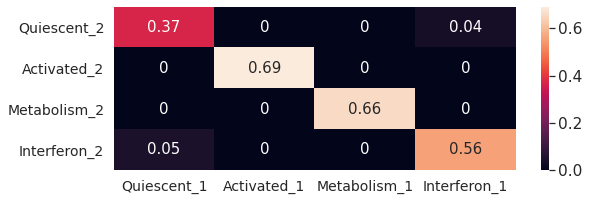

In [8]:
sns.set(font_scale=1.4)

plt.figure(figsize=(9,3))
sns.heatmap(results_df_p, annot=True, annot_kws={"size": 15})
plt.yticks(rotation=0, fontsize = 14) 
plt.xticks(rotation=0, fontsize = 14)
plt.savefig("./figures/overlap_clusters_ct.pdf", dpi=300, bbox_inches='tight')

## 2) Differential proportion analysis

In [9]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import scipy.stats as stats

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [10]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.17.3 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22.2.post1 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [11]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(ggplot2)
library(plyr)

source("diffprop_functions.R");

In [12]:
# read csvs, rename columns, merge and transpose

LT_c_o = pd.read_csv('./write/old_LT_cell_numbers.csv', index_col = 0)
LT_c_n = pd.read_csv('./write/new_LT_cell_numbers.csv', index_col = 0)

LT_c_o.columns = ['ct_o']
LT_c_n.columns = ['ct_n']

LT_c = LT_c_o.merge(LT_c_n, left_index=True, right_index=True)

In [13]:
LT_bg = LT_c.copy()
LT_bg.columns = ['Rep_1', 'Rep_2']
LT_bg

,Rep_1,Rep_2
Quiescent,1185,2614
Activated,930,2196
Metabolism,244,493
Interferon,23,31


In [14]:
perc_LT_bg = LT_bg.iloc[:,0:6].div(LT_bg.sum(axis=0), axis=1)
perc_LT_bg

,Rep_1,Rep_2
Quiescent,0.497481,0.490064
Activated,0.390428,0.411699
Metabolism,0.102435,0.092426
Interferon,0.009656,0.005812


In [15]:
def_colors = [ '#1f77b4', '#ff7f0e', '#279e68', '#aa40fc']

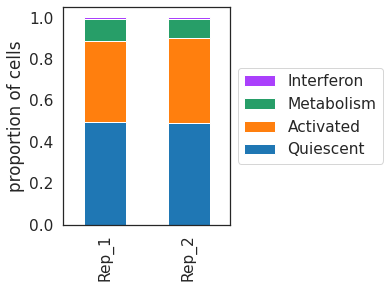

In [16]:
sns.set_style("white")
ax = perc_LT_bg.T.plot.bar(stacked=True, figsize=(3, 4), color = def_colors)
#plt.grid(b=None) # turns off gridlines
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("proportion of cells")
plt.savefig('./figures/old_new_LT_cluster_comparison.pdf', bbox_inches = "tight")

### Without normalization 

In [17]:
LT_c = LT_bg.T
LT_c


,Quiescent,Activated,Metabolism,Interferon
Rep_1,1185,930,244,23
Rep_2,2614,2196,493,31


In [18]:
%%R -i LT_c

## Read in file of counts of cells in each population across conditions
#obs.counts = as.matrix(read.csv("test_prop.csv", row.names = 1))
obs.counts = as.matrix(LT_c)
print(obs.counts)

      Quiescent Activated Metabolism Interferon
Rep_1      1185       930        244         23
Rep_2      2614      2196        493         31


[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
[1] 0.43

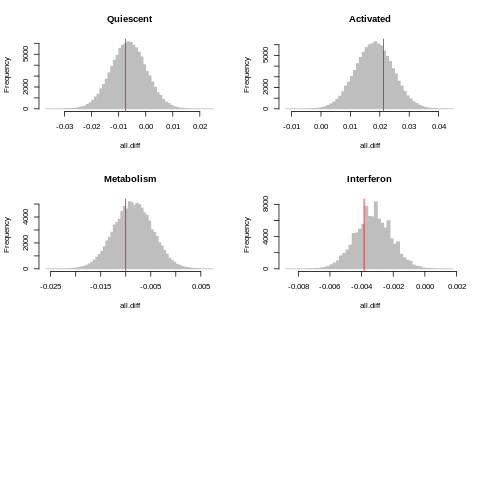

In [19]:
%%R

## Run an example using error (p) of 0.1 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.15);     # Generate the null distribution based on sampling

obs.counts/apply(obs.counts, 1, sum)

### P-value tests for old vs new
two.class.test(obs.counts, tip.exp, cond.control="Rep_1", cond.treatment="Rep_2",to.plot=T);

In [20]:
%%R

## Get a table of P-values for a range of 'p' values - this is essentially the proportion of cells where the label is being switched
res.table = c()
for (err_prob in c(0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001)) {
  all.exp1<-generateNull(obs.counts, n=10000, p=err_prob);
  res = two.class.test(obs.counts, all.exp1, cond.control="Rep_1", cond.treatment="Rep_2",to.plot=F)
  res.table = rbind(res.table, res)
}
rownames(res.table) = as.character(c(0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001))

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000


In [21]:
%%R
#rows are error probability: 0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001
# columns are cluster 

print(res.table)

      Quiescent Activated Metabolism Interferon
0.5      0.3671    0.1537     0.2107     0.1513
0.4      0.3821    0.1900     0.2403     0.1801
0.3      0.3927    0.2280     0.2844     0.2202
0.25     0.4133    0.2556     0.2994     0.2369
0.2      0.4326    0.2825     0.3267     0.2654
0.15     0.4346    0.3112     0.3441     0.2960
0.1      0.4426    0.3370     0.3749     0.3315
0.05     0.4628    0.3881     0.4054     0.3484
0.01     0.4932    0.4567     0.4489     0.2582
0.001    0.4475    0.4338     0.3323     0.0456


### With normalization

In [22]:
# normalize total cell numbers to a total of 1000 - this is necessary so that the an equal amount is resampled/permuted from each condition.
# if one sample had proportionally less cells, less cells would be permuted. 

perc_LT_bg_norm = round(1000 * perc_LT_bg)
perc_LT_bg_norm

,Rep_1,Rep_2
Quiescent,497.0,490.0
Activated,390.0,412.0
Metabolism,102.0,92.0
Interferon,10.0,6.0


In [23]:
LT_c = perc_LT_bg_norm.T

In [24]:
%%R -i LT_c

## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(LT_c)
print(obs.counts)

      Quiescent Activated Metabolism Interferon
Rep_1       497       390        102         10
Rep_2       490       412         92          6


[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
[1] 0.46

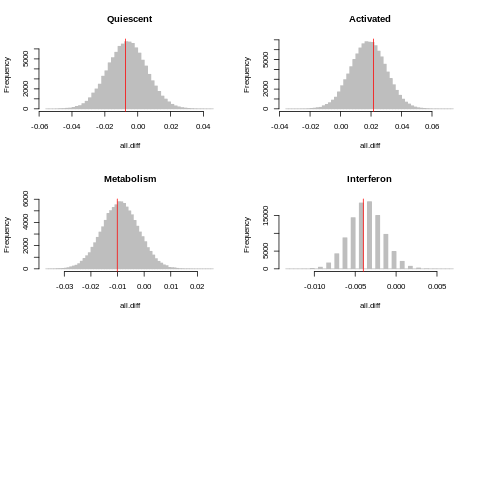

In [25]:
%%R

## Run an example using error (p) of 0.1 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.15);     # Generate the null distribution based on sampling

obs.counts/apply(obs.counts, 1, sum)

### P-value tests for old vs new
two.class.test(obs.counts, tip.exp, cond.control="Rep_1", cond.treatment="Rep_2",to.plot=T);

In [26]:
%%R

## Get a table of P-values for a range of 'p' values - this is essentially the proportion of cells where the label is being switched
res.table = c()
for (err_prob in c(0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001)) {
  all.exp1<-generateNull(obs.counts, n=10000, p=err_prob);
  res = two.class.test(obs.counts, all.exp1, cond.control="Rep_1", cond.treatment="Rep_2",to.plot=F)
  res.table = rbind(res.table, res)
}
rownames(res.table) = as.character(c(0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001))

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000


In [27]:
%%R
# rows are error probability: 0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001
# pick error probability of 0.1 since that has maximum p-value in Interferon 

print(res.table)

      Quiescent Activated Metabolism Interferon
0.5      0.4176    0.2870     0.3301     0.2724
0.4      0.4292    0.3148     0.3431     0.3038
0.3      0.4432    0.3373     0.3784     0.3179
0.25     0.4472    0.3541     0.3826     0.3385
0.2      0.4507    0.3687     0.3984     0.3458
0.15     0.4631    0.3924     0.4037     0.3443
0.1      0.4739    0.4144     0.4228     0.3557
0.05     0.4668    0.4253     0.4422     0.2953
0.01     0.4729    0.4591     0.4283     0.1142
0.001    0.3397    0.3256     0.1480     0.0127


In [28]:
sc.logging.print_versions()
pd.show_versions()

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.17.3 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22.2.post1 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1

INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.19.76-linuxkit
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 0.25.3
numpy            : 1.17.3
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 41.6.0.post20191101
Cython           : None
pytest           : 5.3.5
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.

In [29]:
%%R

sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] plyr_1.8.4    ggplot2_3.2.1

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.3       withr_2.1.2      crayon_1.3.4     dplyr_0.8.3     
 [5] assertthat_0.2.1 grid_3.6.1       R6_2.4.0         gtable_0.3.0    
 [9] magrittr_1.5     scales_1.0.0     pillar_1.4.2     rlang_0.4.1     
[13] lazyeval_0.

In [30]:
!pip list

Package                Version            
---------------------- -------------------
alembic                1.3.0              
anndata                0.7.1              
anndata2ri             1.0.2              
async-generator        1.10               
attrs                  19.3.0             
backcall               0.1.0              
bleach                 3.1.0              
blinker                1.4                
certifi                2019.11.28         
certipy                0.1.3              
cffi                   1.13.2             
chardet                3.0.4              
conda                  4.7.12             
conda-package-handling 1.6.0              
cryptography           2.8                
cycler                 0.10.0             
decorator              4.4.1              
defusedxml             0.6.0              
entrypoints            0.3                
get-version            2.1                
gprofiler-official     1.0.0              
h5py       